In [1]:
                                                                                            # Libraries
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
                                                                                            # libraries
import csv
import pandas as pd
import numpy as np

In [3]:
                                                                                            # reading the dataset
dataSet = 'nyc_taxi'
filePath = dataSet+'.csv'
df = pd.read_csv(filePath, header=0, skiprows=[1,2], names=['time', 'data', 'timeofday', 'dayofweek'])
df.head(5)

,time,data,timeofday,dayofweek
0,2014-07-01 00:00:00,10844,0,1
1,2014-07-01 00:30:00,8127,30,1
2,2014-07-01 01:00:00,6210,60,1
3,2014-07-01 01:30:00,4656,90,1
4,2014-07-01 02:00:00,3820,120,1


In [4]:
numLags = 100
predictionStep = 3

In [5]:
                                                                  # standardize data by subtracting mean and dividing by std
  meanSeq = np.mean(df['data'])
  stdSeq = np.std(df['data'])
  df['data'] = (df['data'] - meanSeq)/stdSeq

In [6]:
                                                                  # getting time embedded matrix
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1):
  print("generate time embedded matrix")
  inDim = numLags
  X_train = np.zeros(shape=(len(sequence), inDim))
  y_train = np.zeros(shape=(len(sequence), 1))
  for i in range(numLags-1, len(sequence)-predictionStep):
    X_train[i, :] = np.array(sequence['data'][(i-numLags+1):(i+1)])
    y_train[i, :] = sequence['data'][i+predictionStep]
  print('input shape: ',X_train.shape)
  print('target shape: ',y_train.shape)
  return (X_train, y_train)

(X_train, y_train) = getTimeEmbeddedMatrix(df, numLags, predictionStep)

generate time embedded matrix
input shape:  (17520, 100)
target shape:  (17520, 1)


In [7]:

def discriminator():                                             # Defining 1D Discriminator
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim = 2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
def generator(latent_dim, outputs=2):                           # Defining 1D Generator
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(outputs, activation='linear'))
    return model

In [9]:
def GAN(generator, discriminator):                              # Defining GAN model
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [10]:
def generate_real_samples(n = 1752000):              # Function to generate real samples
    X1 = X_train - 0.5
    X2 = X1 * X1
    X1 = X1.reshape(n, 1)                            # reshaping it to 1D
    X2 = X2.reshape(n, 1)                            # reshaping it to 1D
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X,y

In [11]:
generate_real_samples()                             # Function call

(array([[-0.5 ,  0.25],
        [-0.5 ,  0.25],
        [-0.5 ,  0.25],
        ...,
        [-0.5 ,  0.25],
        [-0.5 ,  0.25],
        [-0.5 ,  0.25]]), array([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]))

500 0.8778841495513916 0.3581187129020691


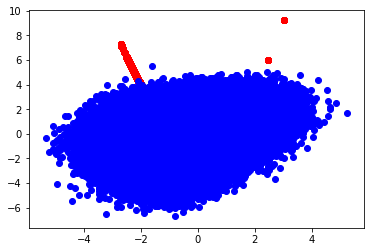

In [68]:
summarize_performance(500,generator, discriminator,latent_dim,1752000 )

1000 0.8778841495513916 0.3574811518192291


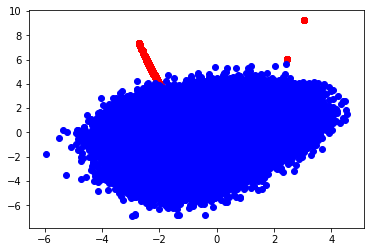

In [69]:
summarize_performance(1000,generator, discriminator,latent_dim,1752000 )

In [12]:
                                                              # create points in given space as input for the generator
def generate_latent_points(latent_dim, n):
                                                              # create points in the given space
    x_input = randn(latent_dim * n)
                                                              # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

                                                             # generator usage to generate fake examples
def generate_fake_samples(generator, latent_dim, n):
                                                             # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
                                                             # predict outputs
    X = generator.predict(x_input)
                                                             # generate class labels
    y = zeros((n, 1))
    return X, y

                                                             # evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=1752000):
                                                             # generate real samples
    x_real, y_real = generate_real_samples(n)
                                                              # predict discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
                                                              # generate fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
                                                             # predict discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
                                                             # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
                                                             # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()


training started 06/02/2020 21:49:33


C:\Users\patel\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1999 0.5218835473060608 0.537579357624054


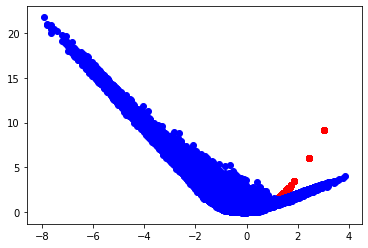

3999 0.23491381108760834 0.7799429297447205


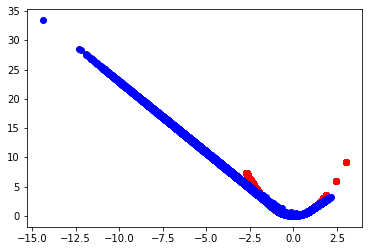

training ended 08/02/2020 10:07:28


In [13]:
                                                                    # train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=5000, n_batch=1752000 , n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch)
                                                                     # manually enumerate epochs
    for i in range(n_epochs):
                                                                     # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
                                                                     # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                                                                     # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
                                                                     # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
                                                                     # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
                                                                     # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
                                                                     # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

                                                                     # size of the latent space
latent_dim = 5
                                                                     # create the discriminator
discriminator = discriminator()
                                                                     # create the generator
generator = generator(latent_dim)
                                                                     # create the gan
gan_model = GAN(generator, discriminator)
                                                                     # train model
from datetime import datetime
                                                                     # datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("training started" ,dt_string)
train(generator, discriminator, gan_model, latent_dim)
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("training ended" ,dt_string)